In [1]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib as mpl
import copy
import matplotlib.dates as mdates
import time
import numpy as np

CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\qchen\Documents\qchen.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [2]:
from pandas.tseries import converter
converter.register() 

In [3]:
pandasql.read_sql(''' 

create temporary table cuts(
	bt_id integer, cut_date date 
);


create temporary table baseline_dates as (
	SELECT DISTINCT aa.bt_id, CASE WHEN EXTRACT(ISODOW FROM ttc.dt) < 6 THEN 'weekday' ELSE 'weekend' END as daytype, ttc.dt

	FROM king_pilot.ttc_tt_30min ttc
		INNER JOIN king_pilot.bt_segments aa USING (bt_id)
		LEFT OUTER JOIN cuts ON (cuts.bt_id = aa.bt_id AND cuts.cut_date = ttc.dt)
		LEFT OUTER JOIN ref.holiday hol USING(dt)

	WHERE cuts.cut_date IS NULL AND
		ttc.dt NOT BETWEEN '2017-10-15' AND '2017-10-29'
		AND hol.dt IS NULL
		AND ttc.dt < '2017-11-05');


create temporary table ttc_baselines as (
	SELECT time_bin, 
	    avg(ttc.tt) as avg_tt,
	    ttc.bt_id,
	    dates.daytype

	FROM king_pilot.ttc_tt_30min ttc
	    INNER JOIN baseline_dates dates ON (dates.bt_id = ttc.bt_id AND dates.dt = ttc.dt) 

	GROUP BY ttc.bt_id, 
	    time_bin, 
	    dates.daytype

	ORDER BY ttc.bt_id, 
	    time_bin, 
	    dates.daytype);


SELECT * FROM ttc_baselines''', con)[:5]

,time_bin,avg_tt,bt_id,daytype
0,00:00:00,252.173913,19,weekday
1,00:00:00,309.111111,19,weekend
2,00:30:00,234.956522,19,weekday
3,00:30:00,293.888889,19,weekend
4,01:00:00,252.086957,19,weekday


In [4]:
pandasql.read_sql('SELECT * FROM ttc_baselines', con)[:5]

,time_bin,avg_tt,bt_id,daytype
0,00:00:00,252.173913,19,weekday
1,00:00:00,309.111111,19,weekend
2,00:30:00,234.956522,19,weekday
3,00:30:00,293.888889,19,weekend
4,01:00:00,252.086957,19,weekday


In [5]:
colors = ['#003A72', '#d83904']

### Scatterplots for given (or all) weeks

In [42]:

travelsql_30 = '''
SELECT ttc.tt, 
    ttc.dt + ttc.time_bin as datetime_bin,
    ttc.bt_id,
    CASE WHEN EXTRACT(ISODOW FROM ttc.dt) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    street_name || ' from ' || from_intersection || ' to ' || to_intersection as report_name
FROM king_pilot.ttc_tt_30min ttc
    INNER JOIN king_pilot.bt_segments aa ON (ttc.bt_id = aa.bt_id)
    LEFT OUTER JOIN ref.holiday hol ON (ttc.dt = hol.dt)

WHERE --hol.dt is NULL
    --AND 
    ttc.dt NOT BETWEEN '2017-10-15' AND '2017-10-29'
    --AND dt < '2017-11-05' --filter baseline date
'''
traveltime_30 = pandasql.read_sql(travelsql_30, con)

In [7]:
traveltime_30

,tt,datetime_bin,bt_id,workingday,report_name
0,220,2017-09-11 05:00:00,19,Work,Queen from Roncesvalles to Dufferin
1,280,2017-09-11 05:30:00,19,Work,Queen from Roncesvalles to Dufferin
2,304,2017-09-11 06:00:00,19,Work,Queen from Roncesvalles to Dufferin
3,307,2017-09-11 06:30:00,19,Work,Queen from Roncesvalles to Dufferin
4,334,2017-09-11 07:00:00,19,Work,Queen from Roncesvalles to Dufferin
5,393,2017-09-11 07:30:00,19,Work,Queen from Roncesvalles to Dufferin
6,447,2017-09-11 08:00:00,19,Work,Queen from Roncesvalles to Dufferin
7,493,2017-09-11 08:30:00,19,Work,Queen from Roncesvalles to Dufferin
8,577,2017-09-11 09:00:00,19,Work,Queen from Roncesvalles to Dufferin
9,490,2017-09-11 09:30:00,19,Work,Queen from Roncesvalles to Dufferin


In [43]:
def WOY(x, W):
    return x.weekofyear == W

def week_dict(seg_name):
    weeks = {W : traveltime_30[(traveltime_30['bt_id'] == seg_name) & 
                 traveltime_30['datetime_bin'].apply(WOY, args = (W,))]
            for W in traveltime_30.datetime_bin.apply(lambda x : x.weekofyear).unique()}
    
    temp = {}
    for week, df in weeks.items():
        if df.tt.count() > 0:
            temp[week] = weeks[week]
        else:
            if week in temp: #discard weeks without data to avoid MAXTICKS error
                del temp[week]
    return temp

Creates a dictionary to store the bluetooth observations (30 minute) divided by week and removes empty weeks to keep the graph clean

In [44]:
def plot_weeks(seg_name):
    weeks = week_dict(seg_name) #returns dictionary with seg_name divided into weeks
    
#     if len(args) > 0: #if plotting specific weeks, trim weeks to contain said weeks
#         temp = {}
#         for week in args:
#             temp[week] = weeks[week]
#         weeks = temp
        
    fig, ax = plt.subplots(len(weeks), 1, sharex = False, sharey = True, figsize = (16, 5*len(weeks)))
    plt.suptitle('Travel times by week for ' + weeks[40].report_name.unique()[0])
    
#     if len(args) == 1: #if there's only one week, there's only one subplot, and ax is not iterable. 
#         temp = []
#         temp.append(ax)
#         ax = temp #oh look, ax is iterable.

    for i, week in enumerate(weeks):
            
            ax[i].plot_date(x = weeks[week].datetime_bin, 
                            y = weeks[week].tt)

            ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = [0, 1, 2, 3, 4, 5, 6])) #axis setup
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('\n%a %Y-%m-%d'))
            ax[i].xaxis.set_minor_locator(mdates.HourLocator(interval = 3))
            ax[i].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
            
            xpad = timedelta(minutes = 60)
            ax[i].set_xlim(min(weeks[week].datetime_bin) - xpad, max(weeks[week].datetime_bin) + xpad)
            
            ax[i].set_title(str(week))# titles & labels
            ax[i].set_xlabel('Time')
            ax[i].set_ylabel('Travel Time')
            ax[i].legend()
            ax[i].xaxis.grid(True, which="major")
            ax[i].yaxis.grid(True, which="major")

    fig.tight_layout() #subplot titles bumping into  main title
    
#     if len(args) > 0:
#         fig.subplots_adjust(top=0.88) # keep titles from getting distracted by their phones and bumping into the axis above.
#     else:
#         fig.subplots_adjust(top=0.965)
    fig.subplots_adjust(top=0.965)
    
    plt.show()

For each segment identified in the baseline lookover, the above function will be used to first plot all weeks, then plot only the weeks with the questionable data, as identified from the first plot.

### Baselines overlaid onto percentile bands query and function

In [58]:
sql = '''SELECT base.daytype, -- percentile bands
	('2017-11-12 ' || base.time_bin::varchar)::timestamp as time_bin,
	base.avg_tt as base_tt,
	base.bt_id,

	percentile_cont(0) WITHIN GROUP (ORDER BY ttc.tt) as pct_0,
	percentile_cont(0.1) WITHIN GROUP (ORDER BY ttc.tt) as pct_10,
	percentile_cont(0.2) WITHIN GROUP (ORDER BY ttc.tt) as pct_20,
	percentile_cont(0.4) WITHIN GROUP (ORDER BY ttc.tt) as pct_40,
    
	percentile_cont(0.6) WITHIN GROUP (ORDER BY ttc.tt) as pct_60,
	percentile_cont(0.8) WITHIN GROUP (ORDER BY ttc.tt) as pct_80,
	percentile_cont(0.9) WITHIN GROUP (ORDER BY ttc.tt) as pct_90,
	percentile_cont(1.0) WITHIN GROUP (ORDER BY ttc.tt) as pct_100,

	max(street_name) || ' from ' || max(from_intersection) || ' to ' || max(to_intersection) as location
	
	
FROM ttc_baselines base
	INNER JOIN king_pilot.ttc_tt_30min ttc ON (ttc.bt_id = base.bt_id AND ttc.time_bin = base.time_bin AND 
		CASE WHEN EXTRACT(ISODOW FROM ttc.dt) < 6 THEN 'weekday' ELSE 'weekend' END = base.daytype)
	INNER JOIN king_pilot.bt_segments bt_seg ON (ttc.bt_id = bt_seg.bt_id)

WHERE ttc.dt <= '2017-11-12'
	AND ttc.dt NOT BETWEEN '2017-10-15' AND '2017-10-29'

GROUP BY base.bt_id, base.time_bin, base.daytype, base.avg_tt
'''

travel_times = pandasql.read_sql(sql, con)

In [59]:
travel_times[:5]

,daytype,time_bin,base_tt,bt_id,pct_0,pct_10,pct_20,pct_40,pct_60,pct_80,pct_90,pct_100,location
0,weekday,2017-11-12 00:00:00,252.173913,19,226.0,234.2,240.0,246.8,256.8,263.8,275.8,312.0,Queen from Roncesvalles to Dufferin
1,weekend,2017-11-12 00:00:00,309.111111,19,225.0,273.0,292.2,311.4,315.4,327.4,338.4,380.0,Queen from Roncesvalles to Dufferin
2,weekday,2017-11-12 00:30:00,234.956522,19,197.0,204.0,214.8,229.2,242.4,266.8,272.4,283.0,Queen from Roncesvalles to Dufferin
3,weekend,2017-11-12 00:30:00,293.888889,19,247.0,257.4,264.2,288.8,296.0,324.8,333.6,340.0,Queen from Roncesvalles to Dufferin
4,weekday,2017-11-12 01:00:00,252.086957,19,120.0,210.0,220.0,240.8,249.6,266.2,286.1,540.0,Queen from Roncesvalles to Dufferin


In [64]:
def plot_base(seg_name):
    #Divide data into Week and Weekend buckets for the given route name. 
    segments = {'week' : travel_times[(travel_times['bt_id'] == seg_name) & 
                         (travel_times['daytype'] == 'weekday')].sort_values(['time_bin']),
                'weekend' : travel_times[(travel_times['bt_id'] == seg_name) & 
                         (travel_times['daytype'] == 'weekend')].sort_values(['time_bin'])}
        
    fig, daytype = plt.subplots(2, 1, figsize = (16,14))
    outliers = []
    
    for i, (color, WD) in enumerate(zip(colors, ['weekend', 'week'])):        
        
        daytype[i].set_title('Baseline for ' + max(segments['week'].location) + ' during the ' + str(WD))
        daytype[i].plot_date(x = segments[WD].time_bin,
                          y = segments[WD].base_tt,
                          xdate = True,
                          fmt = '-o',
                          c = color,
                          label = WD)
        
        daytype[i].fill_between(segments[WD].time_bin.values, 
                            y1=segments[WD]['pct_10'],
                            y2=segments[WD]['pct_90'],
                            alpha=0.15, facecolor=color)
        daytype[i].fill_between(segments[WD].time_bin.values, 
                            y1=segments[WD]['pct_20'],
                            y2=segments[WD]['pct_80'],
                            alpha=0.25, facecolor=color)
        daytype[i].fill_between(x = segments[WD].time_bin.values, 
                            y1=segments[WD]['pct_40'],
                            y2=segments[WD]['pct_60'],
                            alpha=0.35, facecolor=color)
               
        daytype[i].set_xlim(min(segments[WD].time_bin) - timedelta(minutes = 30), max(segments[WD].time_bin) + timedelta(minutes = 30))
        daytype[i].xaxis.set_major_locator(mdates.HourLocator(byhour = range(0,24), interval = 3))
        daytype[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        
        daytype[i].xaxis.set_label_text('Time')
        daytype[i].yaxis.set_label_text('Travel Time')
        
        daytype[i].yaxis.grid(True)
        daytype[i].xaxis.grid(True)
        
        outliers.append(daytype[i].twiny())
        
        outliers[i].plot_date(x = segments[WD]['time_bin'],
                              y = segments[WD]['pct_100'],
                              fmt = '+',
                              xdate = True,
                      #       alpha = 0.35,
                              c = color)
        
        outliers[i].plot_date(x = segments[WD]['time_bin'],
                              y = segments[WD]['pct_0'],
                              fmt = 'x',
                              xdate = True,
                      #       alpha = 0.35,
                              c = color)
        
        outliers[i].xaxis.set_visible(False)
        outliers[i].set_xlim(min(segments[WD].time_bin) - timedelta(minutes = 30), max(segments[WD].time_bin) + timedelta(minutes = 30))
    
    daytype[0].legend()
    daytype[1].legend(loc = 'upper left')
    
    plt.show()

### Plot baseline with prospective outliers removed against old baseline

In [47]:
def daystring(cut_days):
    cut_day_str = '(\'' + cut_days[0]
    for day in cut_days[1:]:
        cut_day_str = cut_day_str + '\', \'' + day
    return cut_day_str + '\')'

In [48]:
new_sql = '''SELECT '2017-11-12'::date + time_bin as time_bin, 
    avg(ttc.tt) as tt,
    CASE WHEN EXTRACT(ISODOW FROM ttc.dt) < 6 THEN 'weekday' ELSE 'weekend' END as daytype,
    bt_id,
    max(street_name) || ' from ' || max(from_intersection) || ' to ' || max(to_intersection) as location

FROM king_pilot.ttc_tt_30min ttc
	INNER JOIN king_pilot.bt_segments bt_seg USING (bt_id)
        LEFT OUTER JOIN ref.holiday hol ON (ttc.dt = hol.dt)

WHERE ttc.dt  NOT IN {0} AND -- removes suspicious days
         ttc.dt NOT BETWEEN '2017-10-15' AND '2017-10-29' --removes construction period
        AND hol.dt is NULL

GROUP BY bt_id, 
    time_bin, 
    daytype'''


old_sql = '''SELECT '2017-11-12'::date + time_bin as time_bin, 
    avg(ttc.tt) as tt,
    CASE WHEN EXTRACT(ISODOW FROM ttc.dt) < 6 THEN 'weekday' ELSE 'weekend' END as daytype,
    ttc.bt_id,
    max(street_name) || ' from ' || max(from_intersection) || ' to ' || max(to_intersection) as location

FROM king_pilot.ttc_tt_30min ttc
	INNER JOIN king_pilot.bt_segments bt_seg USING (bt_id)
        LEFT OUTER JOIN ref.holiday hol ON (ttc.dt = hol.dt)

WHERE ttc.dt NOT BETWEEN '2017-10-15' AND '2017-10-29' --removes construction period
        AND hol.dt is NULL

GROUP BY bt_id, 
    time_bin, 
    daytype'''

The baseline query from above, modified to exclude anomalistic dates.

In [49]:
def alternate_baseline(r_name, cut_day_str):
    
    new_base = pandasql.read_sql(new_sql.format(daystring(cut_day_str), r_name), con)
    old_base = pandasql.read_sql(old_sql.format(r_name), con)
    
    fig, days = plt.subplots(2, 1, figsize = (16,16))
    old = []

    segments = {order : {'Work' : observations[(observations['bt_id'] == r_name) & 
                                               (observations['daytype'] == 'weekday')].sort_values(['time_bin']),
                         'Weekend' : observations[(observations['bt_id'] == r_name) & 
                                                    (observations['daytype'] == 'weekend')].sort_values(['time_bin'])}
                for order, observations in zip(['New', 'Old'],[new_base, old_base])}


    for i, WD in enumerate(['Work', 'Weekend']):
        old.append(days[i].twiny())
        days[i].plot_date(x = segments['New'][WD].time_bin,
                          y = segments['New'][WD].tt,
                          xdate = True,
                          fmt = '-o',
                          c = colors[0],
                          alpha = 0.5,
                          label = 'New Baseline')
        plt.legend()
        old[i].plot_date(x = segments['Old'][WD].time_bin,
                         y = segments['Old'][WD].tt,
                         xdate = True,
                         fmt = '-o',
                         c = colors[1],
                         alpha = 0.5,
                         label = 'Old Baseline')

        maj = mdates.HourLocator(interval = 3)
        days[i].xaxis.set_major_locator(maj)
        days[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

        #old[i].set_yticks(np.linspace(days[i].get_yticks()[0],days[i].get_yticks()[-1],len(days[i].get_yticks())))
        old[i].get_xaxis().set_visible(False)
        #old[i].get_yaxis().set_visible(True)

        #old[i].get_yaxis().set_visible(False)


        plt.title(str(WD) + ' Baseline for ' + new_base[new_base.bt_id == r_name]['location'].unique())

        days[i].xaxis.set_label_text('Time')
        days[i].yaxis.set_label_text('Travel Time')

        days[i].legend()
        old[i].legend(loc = 'upper left')

        fig.tight_layout()

    plt.show()

Dates affecting baselines:
parliament NB Queen to Dundas, September 24th
Jasrvis NB King to Queen, September 16th
Dufferin SB Queen to King, November 5th
Front EB Jarvis to Parliament, September 16th
Adelaide EB Jarvis to Parliament, October 30th, 31st, November 1st. More than single point. 
Queen WB Spadina to Bathurst September 19th.
Queen Yonge to University, Spetember 30th, October 1st, Nuit Blanche
Queen University to Yonge, September 24th, 30th, October 1st. Nuit Blanche and Single point.

##### The function plotting baselines returns both a weekend (blue) and weekday (orange) plot. Becasue of this not all baseline plots will be anomalistic.

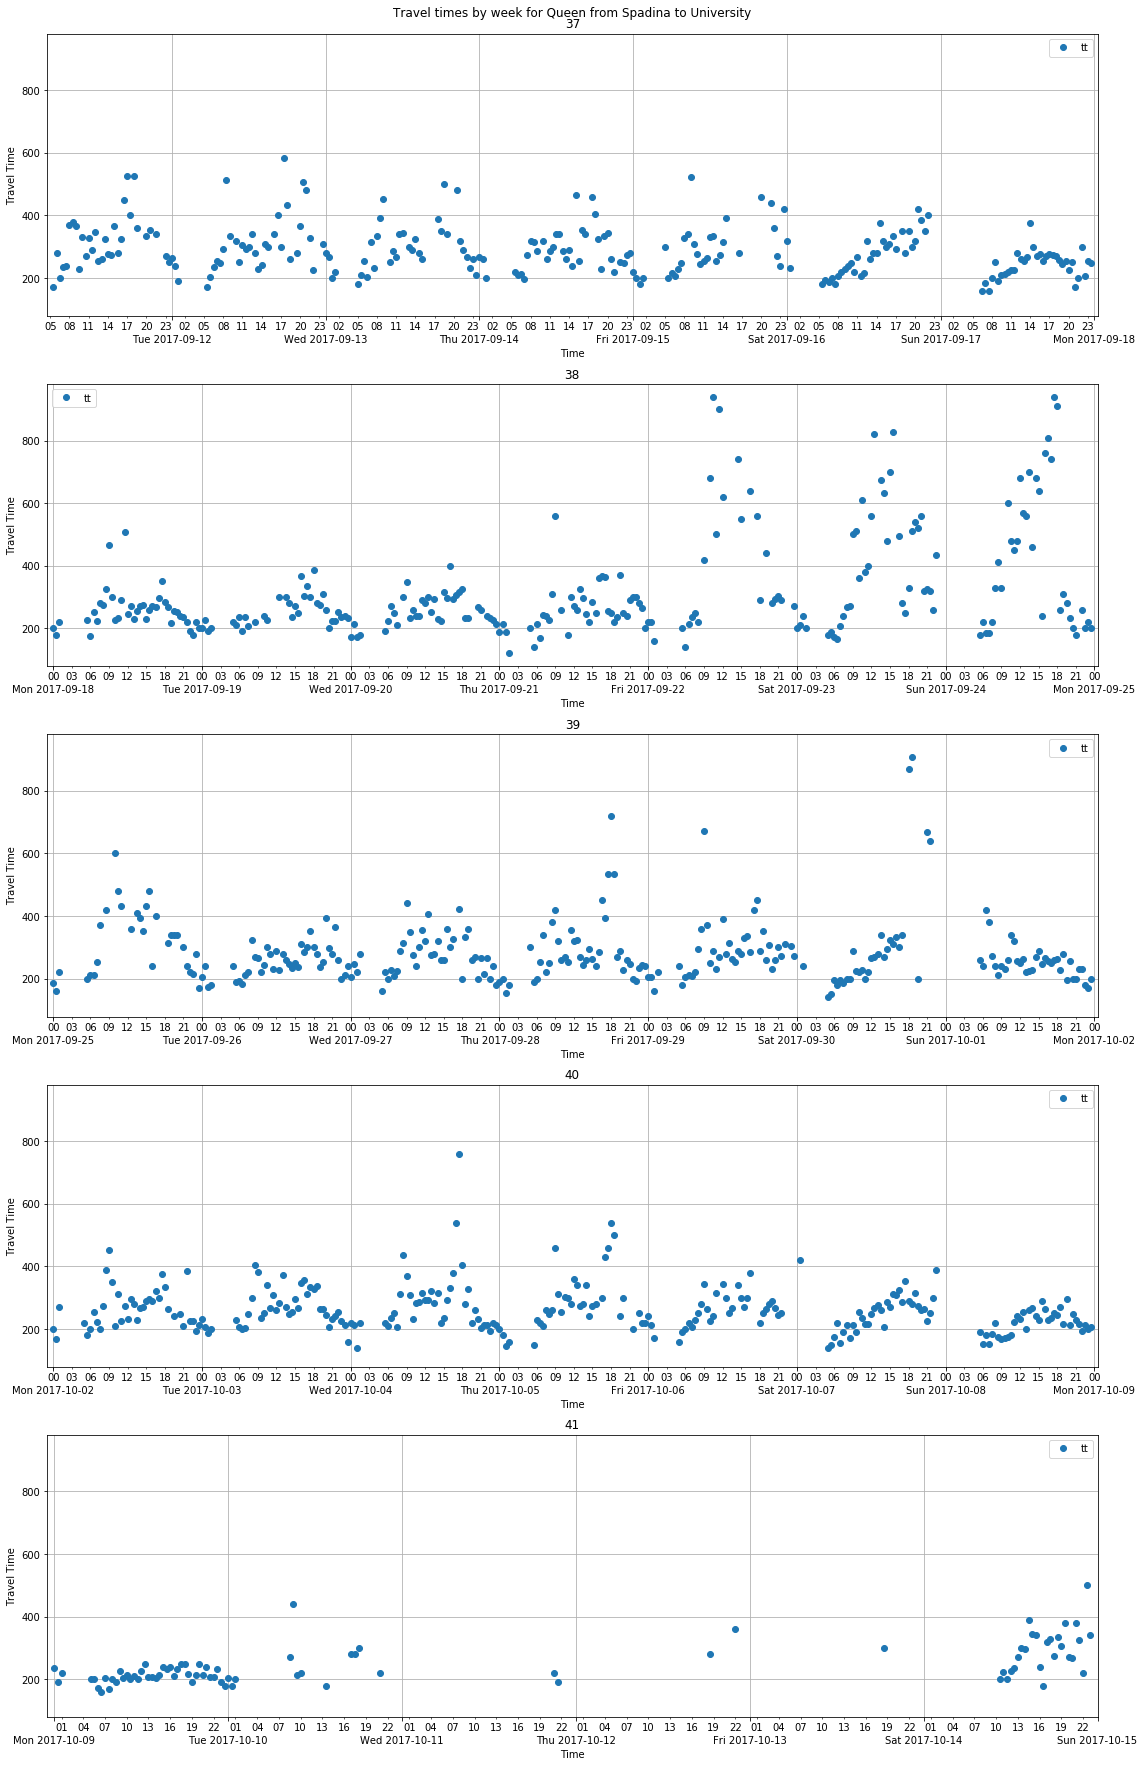

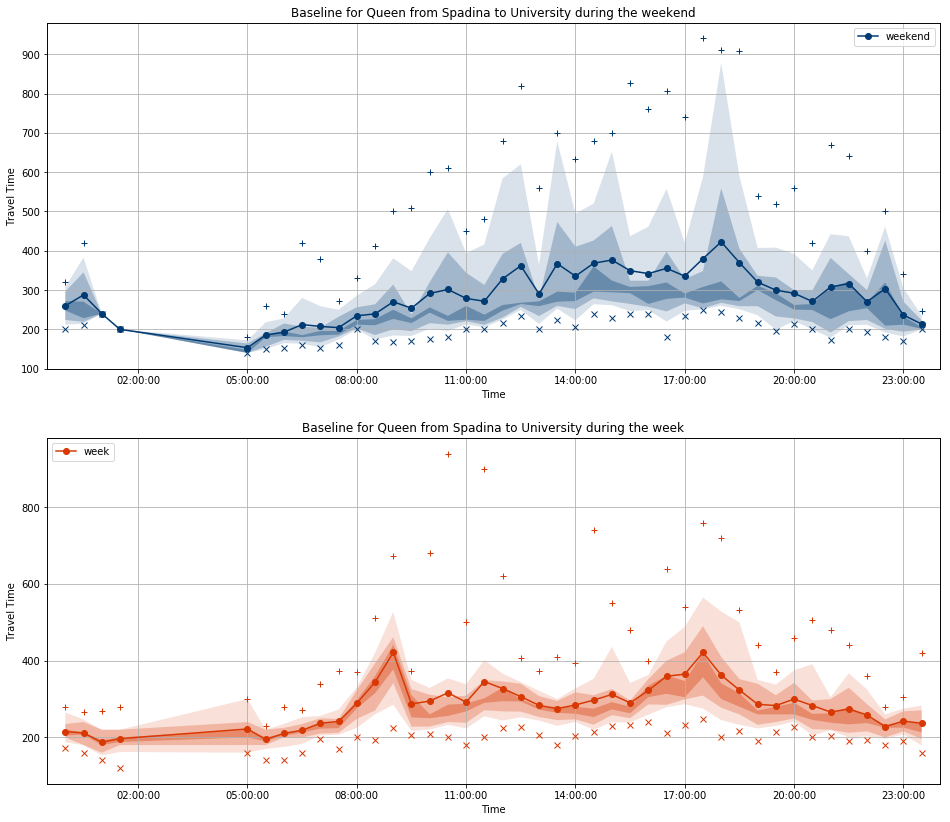

In [111]:
bt_id = 23
plot_weeks(bt_id)
plot_base(bt_id)
#alternate_baseline(bt_id, ['2017-09-30', '2017-10-01']) #optional date arguments

In [39]:
#for bt_id in travel_times.bt_id.unique():
#    plot_weeks(bt_id)
#    plot_base(bt_id)
#    alternate_baseline(bt_id, ['2017-09-30', '2017-10-01'])